In [206]:
#%matplotlib widget

In [207]:
from ephysvibe.structures.neuron_data import NeuronData
import numpy as np
from dPCA import dPCA
import matplotlib.pyplot as plt
import os
import glob
from ephysvibe.trials import align_trials
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.task import task_constants
import platform
from joblib import Parallel, delayed
from tqdm import tqdm
import h5py
from pathlib import Path
from typing import Dict,List
#import pca_tools
seed=31

### Define functions

In [208]:
def to_python_hdf5(dat:List, save_path: Path):
    """Save data in hdf5 format."""
    # save the data
    with h5py.File(save_path, "w") as f:
        for i_d in range(len(dat)):
            group = f.create_group(str(i_d))

            for key, value in zip(dat[i_d].keys(), dat[i_d].values()):
                group.create_dataset(key, np.array(value).shape, data=value)
    f.close()

In [209]:
def from_python_hdf5(load_path: Path):
    """Load data from a file in hdf5 format from Python."""
    with h5py.File(load_path, "r") as f:
        data = []
        for i_g in f.keys():
            group = f[i_g]
            dataset={}
            for key, value in zip(group.keys(), group.values()):
                dataset[key] = np.array(value)
            data.append(dataset)
    f.close()
    return data

In [210]:
def z_score(x):
    mu = np.mean(x,axis=0)
    sigma = np.std(x,axis=0)
    sigma0=sigma
    sigma0[sigma == 0] = 1 
    zs_x = (x-mu) / sigma0
    return zs_x

In [211]:
def get_fr_samples(sp,sample_id,start,end,samples,rng):
    # parameters
    n_trials = 15
    win=50
    # Check fr
    ms_fr=np.nanmean(sp[:,start:end])*1000>5
    if not ms_fr:
        return None
    # Average spikes
    avg_sample = firing_rate.moving_average(sp, win=win, step = 1)
    fr_samples = []
    for s_id in samples:
        sample_fr = avg_sample[np.where(sample_id==s_id,True,False),start:end]
        # Check number of trials
        if sample_fr.shape[0]< n_trials:
            return None
        rng = np.random.default_rng(seed=seed)
        trials_list = rng.choice(sample_fr.shape[0], size=n_trials, replace=False)
        fr_samples.append(sample_fr[trials_list])
    return np.array(fr_samples)

In [212]:
def get_neuron_sample_fr(path,time_before,start,end,rng):
    neu_data = NeuronData.from_python_hdf5(path)
    select_block=1
    code=1
    idx_start = time_before + start 
    idx_end = time_before+end
    # Select trials aligned to sample onset
    sp_sample_on,mask = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="sample_on",
        time_before = time_before,
        error_type= 0,
    )
    if np.sum(mask)<50:
        return {'fr':None}
    #non_zero_mask = np.sum(sp_sample_on[:,idx_start:idx_end],axis=1)>0
    sample_id = neu_data.sample_id[mask]#[non_zero_mask]
    fr_samples = get_fr_samples(sp_sample_on,sample_id,start=idx_start,end=idx_end,samples=[0,11,15,55,51],rng=rng)
    if fr_samples is None:
        return {'fr':None}
    return {'fr':fr_samples}

In [213]:
def get_neuron_sample_test1_fr(path,time_before,start,end,end_test,n_test,rng):
    neu_data = NeuronData.from_python_hdf5(path)
    select_block=1
    code=1
    idx_start = time_before + start 
    idx_end = time_before+end
    # Select trials aligned to sample onset
    sp_sample_on, mask_sample = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="sample_on",
        time_before = time_before,
        error_type= 0,
    )
    sp_test1_on, mask_test1 = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="test_on_1",
        time_before = 200,
        error_type= 0,
    )
    if np.any(mask_sample != mask_test1):
        print(path)
        return 
    mask_match=np.where(neu_data.test_stimuli[mask_test1,n_test-1]==neu_data.sample_id[mask_test1],True,False)
    mask_neu = neu_data.sample_id[mask_test1]==0
    mask_match_neu = np.logical_or(mask_match,mask_neu)
    if np.sum(mask_match_neu)<20:
        return {'fr':None}
 
    sp=np.concatenate((sp_sample_on[mask_match_neu,:time_before+450+200],sp_test1_on[mask_match_neu,:end_test+400]),axis=1)

    sample_id = neu_data.sample_id[mask_test1][mask_match_neu]
    fr_samples = get_fr_samples(sp,sample_id,start=idx_start,end=idx_end,samples=[0,11,15,55,51])
    if fr_samples is None:
        return {'fr':None}
    return {'fr':fr_samples}

### Read data

In [214]:
if platform.system() == 'Linux':
    basepath = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/'
elif platform.system() == 'Windows':
    basepath = 'C:/Users/camil/Documents/int/'

In [215]:
area='v4'
neu_path = basepath+'/session_struct/'+area+'/neurons/*neu.h5'
path_list = glob.glob(neu_path)

In [216]:
# Load data
n_test=0
time_before=500
start=-200
end_test = n_test*450+200
end=450+200+200#+end_test

idx_start = time_before + start 
idx_end = time_before+end

In [217]:
T=end-start
T

1050

In [218]:
rng = np.random.default_rng(seed=seed)
data = Parallel(n_jobs = -1)(delayed(get_neuron_sample_fr)(path,time_before,start,end,rng) for path in tqdm(path_list))

0it [00:00, ?it/s]


In [219]:
neurons_fr = []
N = 0
for asc in data:
    fr = asc["fr"]
    if fr is not None:
        N+=1
        neurons_fr.append(fr)
#to_python_hdf5(dat=neurons_fr, save_path='/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/dpca/data/'+area+'_win50_test'+str(n_test)+'_dpca.h5')

In [220]:
N

0

In [221]:
# neurons_fr_read=from_python_hdf5(load_path='/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/dpca/data/'+area+'_win50_test'+str(n_test)+'_dpca.h5')
# neurons_fr = []
# for asc in neurons_fr_read:
#     fr = asc["fr"]
#     if fr is not None:
#         fr_concat = np.concatenate(fr,axis=0)
#         neurons_fr.append(fr_concat)

In [222]:
neurons_fr = np.array(neurons_fr)#.reshape(-1,1050)
neurons_fr =np.transpose(neurons_fr,(2,0,1,3))
neurons_fr.shape

ValueError: axes don't match array

In [ ]:
neurons_fr.shape

(15, 200, 5, 1050)

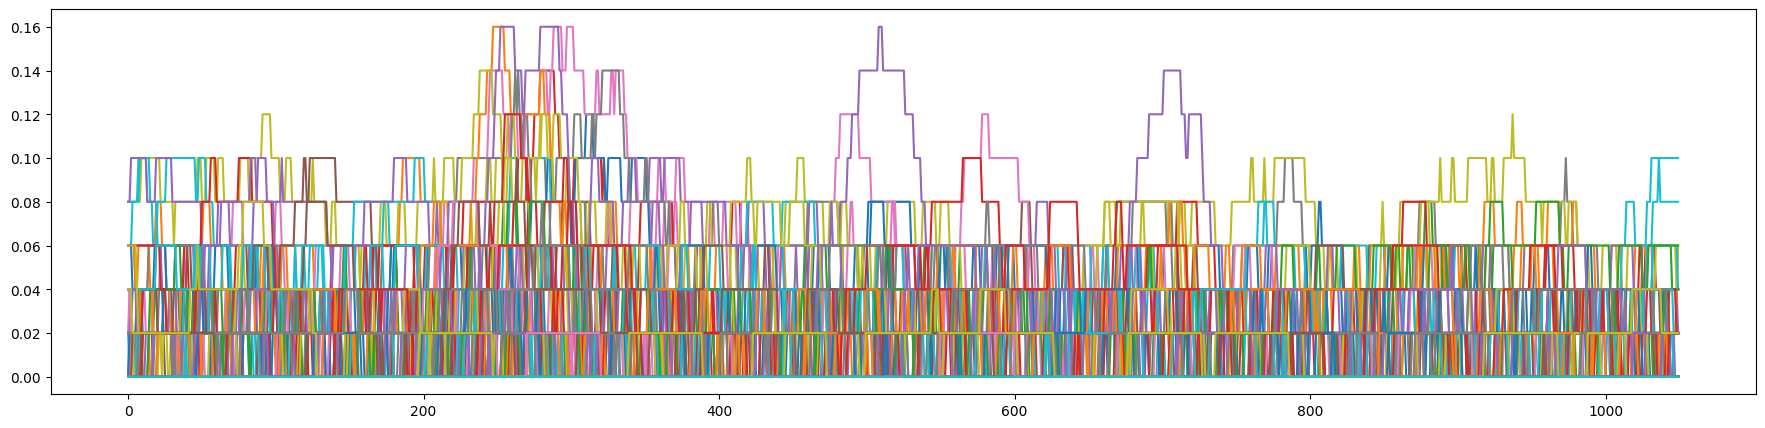

In [ ]:
plt.subplots(figsize=(22,5))
_=plt.plot(neurons_fr[0,:,0,:1200].T)

In [ ]:
neurons_fr.shape

(15, 200, 5, 1050)

In [ ]:
# trial-average data
R = np.mean(neurons_fr,0)

# center data
R -= np.mean(R.reshape((N,-1)),1)[:,None,None]

In [ ]:
dpca = dPCA.dPCA(labels='st',regularizer=0,n_components=neurons_fr.shape[1],n_iter=5)
dpca.protect = ['t']
dpca.n_trials = 3

In [ ]:
# dpca.D['s'].shape
# dpca.P['s'].shape

In [ ]:
Z = dpca.fit_transform(R,neurons_fr)

In [ ]:
samples={
    "o0_c0": 0,
    "o1_c1": 1,
    "o1_c5": 2,
    "o5_c5": 3,
    "o5_c1": 4,
}

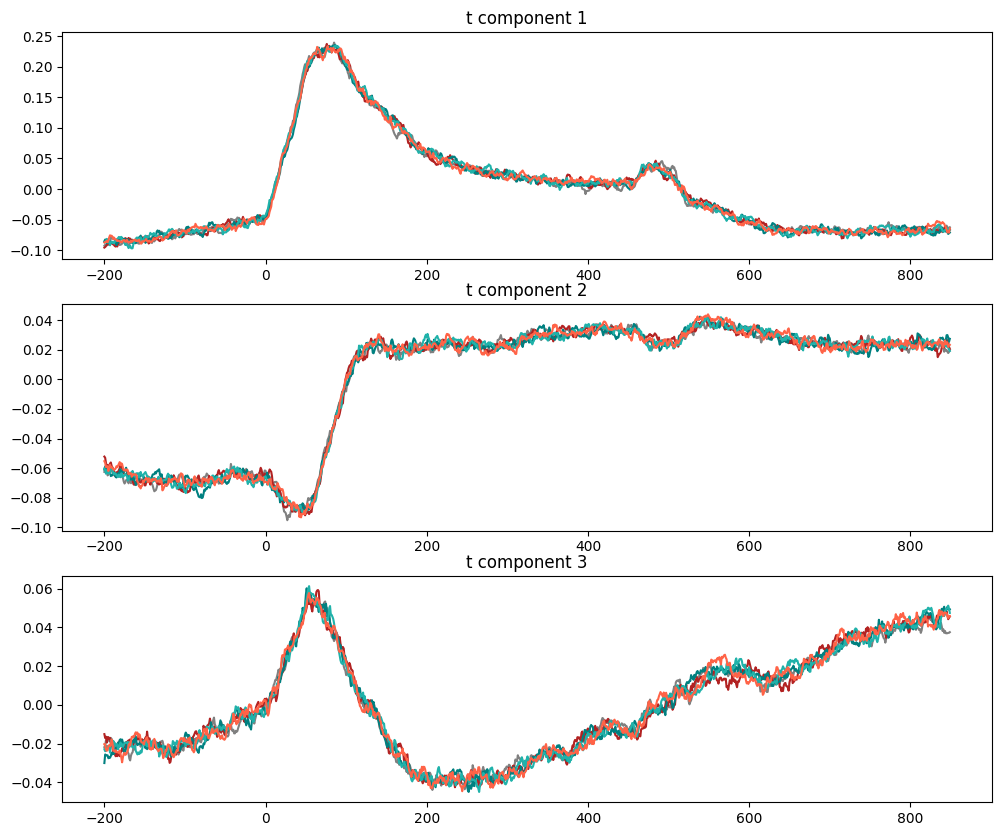

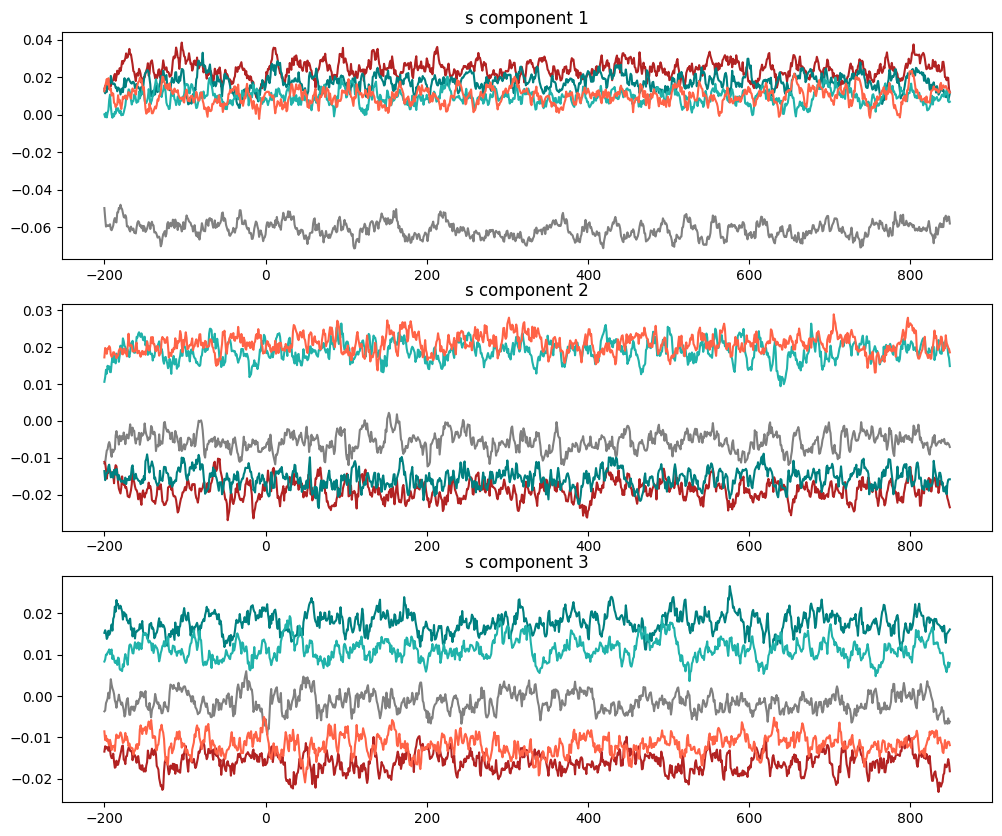

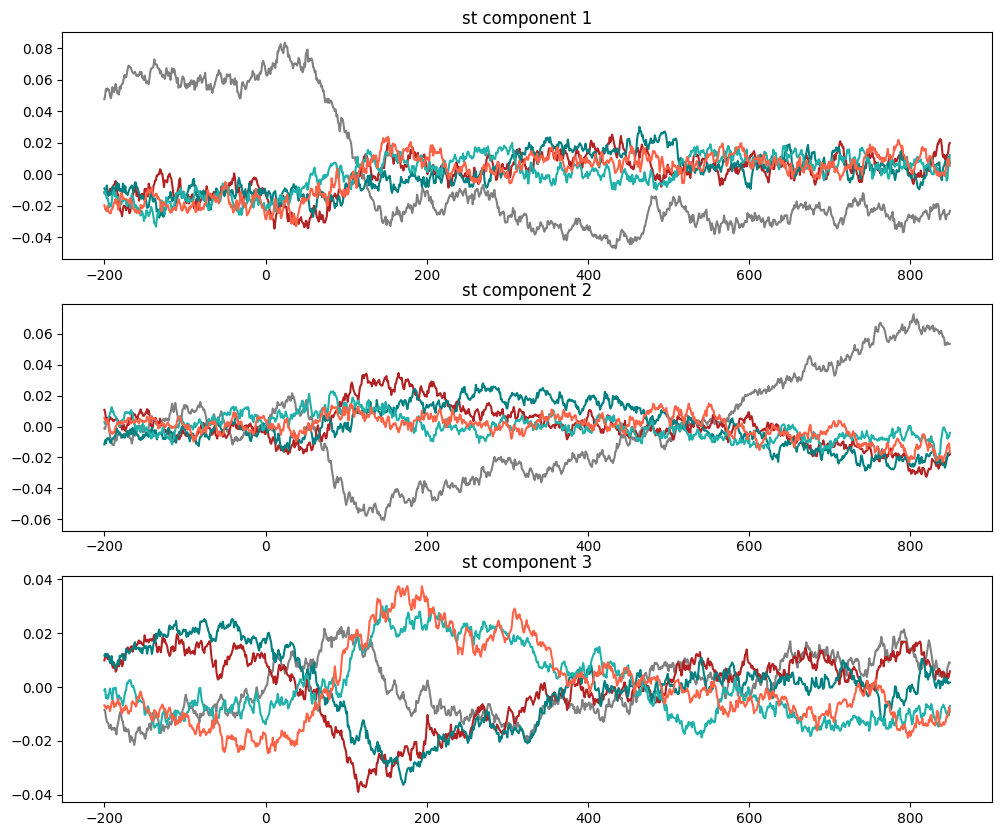

In [ ]:
for c_type in ['t','s','st']:
    time = np.arange(T)+start
    f,ax=plt.subplots(3,1,figsize=(12,10))
    for s in samples.keys():
        ax[0].plot(time,Z[c_type][0,samples[s]],color=task_constants.PALETTE_B1[s])
        ax[1].plot(time,Z[c_type][1,samples[s]],color=task_constants.PALETTE_B1[s])
        ax[2].plot(time,Z[c_type][2,samples[s]],color=task_constants.PALETTE_B1[s])
    ax[0].set(title='%s component %d'%(c_type,0+1))
    ax[1].set(title='%s component %d'%(c_type,1+1))
    ax[2].set(title='%s component %d'%(c_type,2+1))




In [ ]:
n_comp = 10
var_ratio = dpca.explained_variance_ratio_
print(np.array(var_ratio['s'][:n_comp])*100)
print(np.array(var_ratio['t'][:n_comp])*100)
print(np.array(var_ratio['st'][:n_comp])*100)
var_concat = np.concatenate([var_ratio['s'][:n_comp],var_ratio['t'][:n_comp],var_ratio['st'][:n_comp]])*100
comp_concat = np.concatenate([['s']*n_comp,['t']*n_comp,['st']*n_comp])

[5.95223358e+00 1.76679503e+00 1.04638685e+00 5.70525742e-01
 1.52904035e-30 9.28899325e-31 4.22951981e-31 2.24733735e-31
 1.47859097e-31 1.40840151e-31]
[40.82809687 11.22041687  4.45894617  4.23002821  2.3930479   1.66881125
  0.84247579  0.60150172  0.394252    0.32112877]
[2.66289419 1.85588081 1.04571282 0.83976638 0.65389727 0.5958153
 0.54760129 0.4873929  0.45469913 0.42281196]


In [ ]:
import pandas as pd

df=pd.DataFrame({'component':comp_concat,'variance':var_concat})

In [ ]:
df=df.sort_values(by='variance',ascending=False)[:15]

In [ ]:
len(df)

15

81.46538999338586


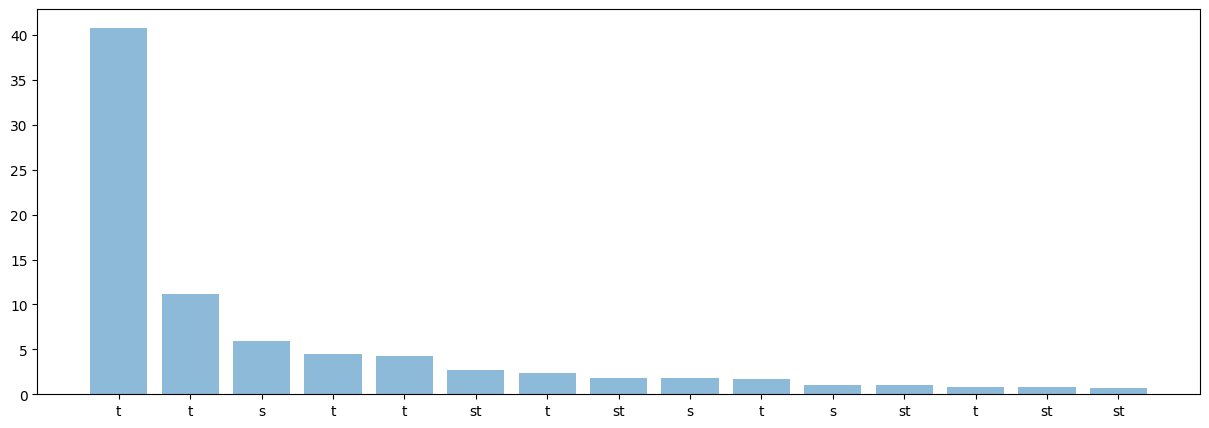

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(
    range(0, len(df)),
    df['variance'],
    alpha=0.5,
    align="center",
    label="Individual explained variance",
)
_=ax.set(xticks=(range(len(df))),xticklabels=df['component'].values)
print(df['variance'].sum())

In [ ]:
var_ratio = dpca.explained_variance_ratio_
var_ratio=np.sort(np.concatenate((var_ratio['s'],var_ratio['t'],var_ratio['st'])))[::-1]

lip: 13 components to explain 80% of the variance


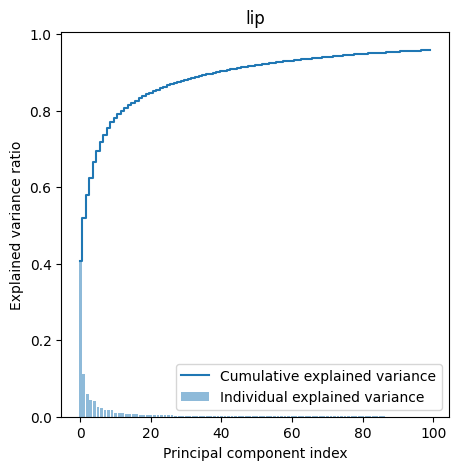

In [ ]:
figsize=(5,5)
fig, ax = plt.subplots(figsize=figsize)
exp_var_pca = var_ratio[:100]
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
# Create the visualization plot
ax.bar(
    range(0, len(exp_var_pca)),
    exp_var_pca,
    alpha=0.5,
    align="center",
    label="Individual explained variance",
)
ax.step(
    range(0, len(cum_sum_eigenvalues)),
    cum_sum_eigenvalues,
    where="mid",
    label="Cumulative explained variance",
)
ax.set(
    xlabel="Principal component index",
    ylabel="Explained variance ratio",
    title=area,
)
ax.legend(loc="best")
print(
    "%s: %d components to explain 80%% of the variance"
    % (area, np.where(cum_sum_eigenvalues > 0.8)[0][0])
)


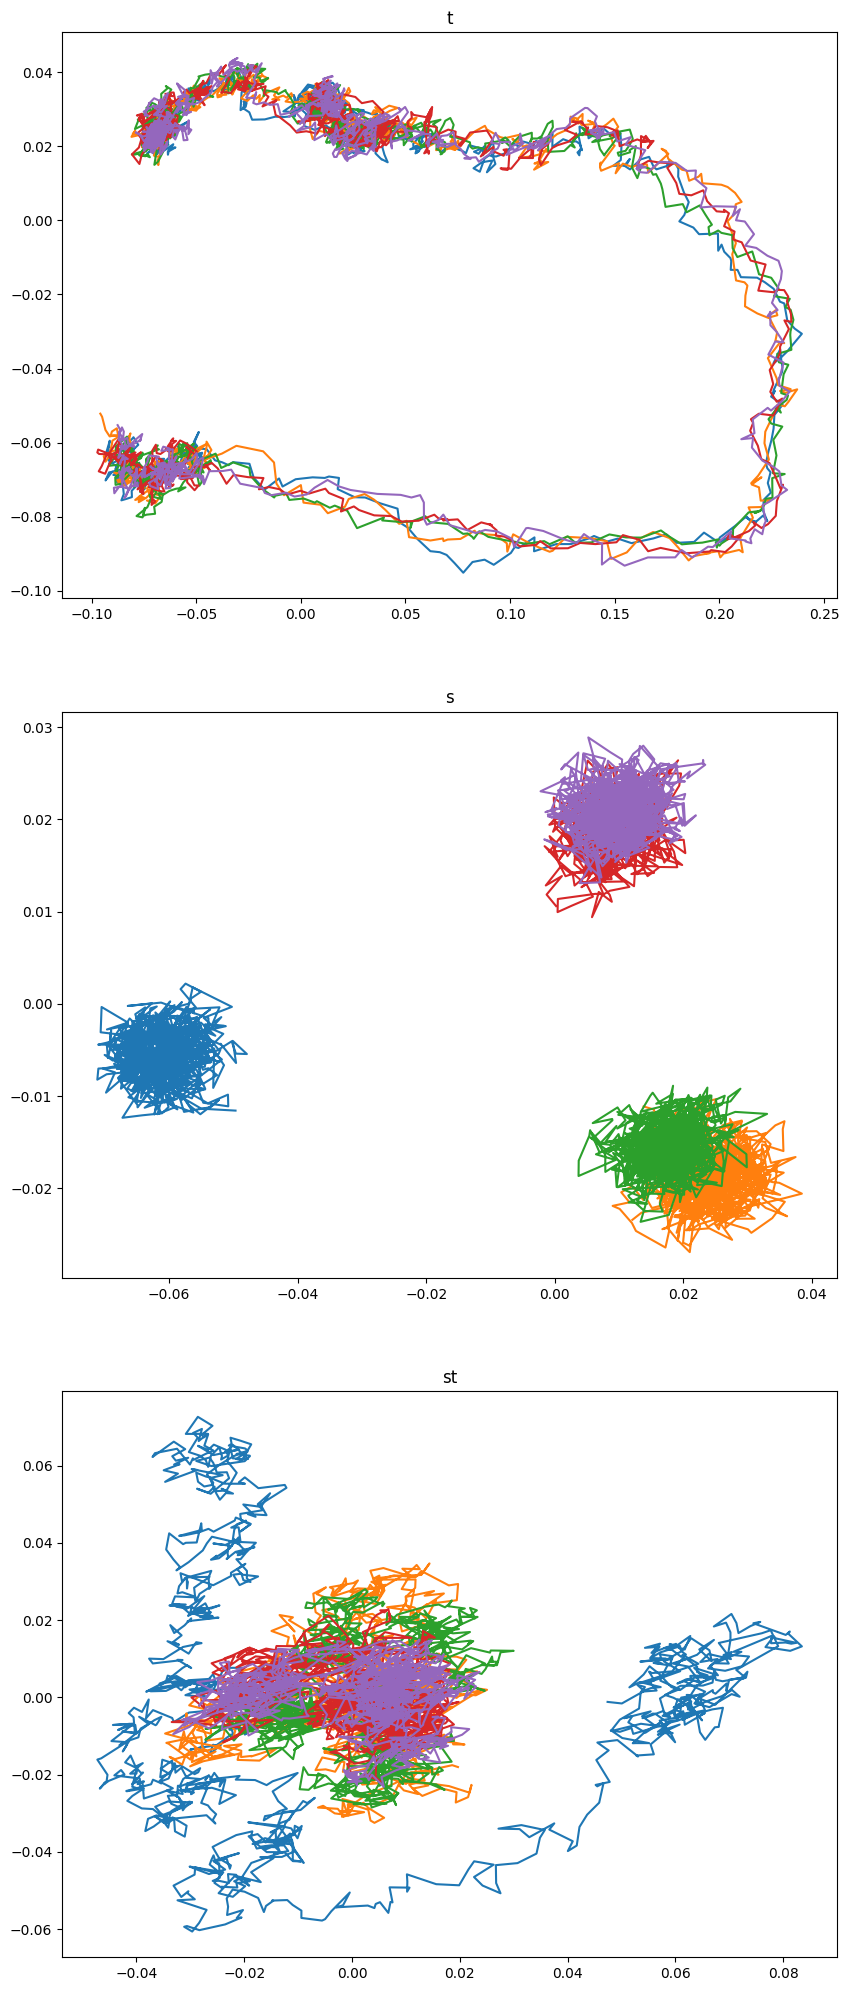

In [ ]:

time = np.arange(T)+start
f,ax=plt.subplots(3,1,figsize=(10,25))
for s in range(5):
    ax[0].plot(Z['t'][0,s],Z['t'][1,s])
    ax[0].set(title='t')
for s in range(5):
    ax[1].plot(Z['s'][0,s],Z['s'][1,s])
    ax[1].set(title='s')
for s in range(5):
    ax[2].plot(Z['st'][0,s],Z['st'][1,s])
    ax[2].set(title='st')
